In [11]:
! curl http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron1.tar.gz --output enron1.tar.gz
! tar -xf enron1.tar.gz enron1 # x: 파일 압축 해제 / f: 압축될 파일명 지정
! ls enron1/ham/*.txt | wc -l # print the number of non-spam emails
! ls enron1/spam/*.txt | wc -l # print the number of spam emails

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1760k  100 1760k    0     0   325k      0  0:00:05  0:00:05 --:--:--  423k
3672
1500


In [12]:
import glob, os

emails, labels = [], []
parition = 0

file_path = 'enron1/spam'

for fname in glob.glob(os.path.join(file_path, '*.txt')):
    with open(fname, 'r', encoding='ISO-8859-1') as f: # [!important] check encoding format
        emails.append(f.read())
        labels.append(1)

file_path = 'enron1/ham'
for fname in glob.glob(os.path.join(file_path, '*.txt')):
    with open(fname, 'r', encoding='ISO-8859-1') as f: 
        emails.append(f.read())
        labels.append(0) 

In [13]:
print(len(emails))
print(len(labels))

5172
5172


In [18]:
import nltk
nltk.download('names')
nltk.download('wordnet')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
# remove number and punctuation 
def letters_only(word):
    return word.isalpha()

# remove name entity
from nltk.corpus import names
all_names = set(names.words())

# lemmaization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# put all together to clean texts
def clean_text(doc):
    cleaned_doc = []
    for word in doc.split(' '): # split doc. by blank (' ')
        word = word.lower() # ABD -> abd
        if letters_only(word) and word not in all_names and len(word) > 2: # remove number and punc. and name entity
            cleaned_doc.append(lemmatizer.lemmatize(word))
            
    return ' '.join(cleaned_doc) 

cleaned_emails = [clean_text(doc) for doc in emails]

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, Y_train, Y_test = train_test_split(cleaned_emails, labels, test_size=0.33, random_state=1213)

cv = CountVectorizer(stop_words='english', max_features=500)
term_docs_train = cv.fit_transform(X_train) # get counter vector for X_train
term_docs_test = cv.transform(X_test) # get counter vector for X_test

In [21]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior = True)
clf.fit(term_docs_train, Y_train)

prediction_prob = clf.predict_proba(term_docs_test)
prediction = clf.predict(term_docs_test)
print(prediction_prob[1:10])
print(prediction[1:10])

[[9.99985009e-001 1.49906292e-005]
 [7.03896104e-001 2.96103896e-001]
 [1.00000000e+000 7.03505109e-016]
 [9.74275079e-006 9.99990257e-001]
 [1.00000000e+000 4.65092762e-020]
 [8.09527122e-003 9.91904729e-001]
 [7.49718875e-009 9.99999993e-001]
 [1.00000000e+000 5.71723581e-306]
 [9.99999999e-001 1.24533161e-009]]
[0 0 0 1 0 1 1 0 0]


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

confusion_matrix(Y_test, prediction, labels=[0, 1])

array([[1122,  111],
       [  71,  403]])

In [23]:
accuracy = clf.score(term_docs_test, Y_test)
print(accuracy)

0.8933801991798477


In [24]:
print(precision_score(Y_test, prediction, pos_label=1))
print(recall_score(Y_test, prediction, pos_label=1))
print(f1_score(Y_test, prediction, pos_label=1))
print(f1_score(Y_test, prediction, pos_label=0))
# 다양한 지표들을 통한 학습
# 간단히 함수로 계산 가능

0.7840466926070039
0.8502109704641351
0.8157894736842106
0.9249793899422918


In [25]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1233
           1       0.78      0.85      0.82       474

    accuracy                           0.89      1707
   macro avg       0.86      0.88      0.87      1707
weighted avg       0.90      0.89      0.89      1707



In [26]:
import numpy as np
# ROC Curve : 임계치에 따른 Sensitivity, Specificity값 계산

pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)

In [27]:
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else :
                false_pos[i] += 1
        else:
            break

In [28]:
true_pos_rate = [tp / np.count_nonzero(Y_test) for tp in true_pos]
false_pos_rate = [fp / (len(Y_test)-np.count_nonzero(Y_test)) for fp in false_pos]
print(true_pos_rate)
print(false_pos_rate)

[1.0, 0.9831223628691983, 0.9662447257383966, 0.8881856540084389, 0.8755274261603375, 0.8502109704641351, 0.8354430379746836, 0.8227848101265823, 0.7827004219409283, 0.7426160337552743, 0.2088607594936709, 0.0]
[1.0, 0.10867802108678021, 0.10462287104622871, 0.09245742092457421, 0.09164639091646391, 0.09002433090024331, 0.08759124087591241, 0.08434712084347121, 0.08110300081103, 0.07948094079480941, 0.014598540145985401, 0.0]


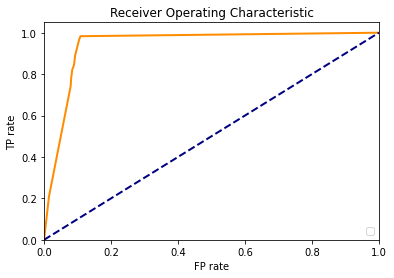

In [29]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1],[0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob) #적분값, AUC score이 1에 가까울 수록 좋은 성능

0.9488794439824653

In [31]:
# K_fold Cross Validation
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k)

cleaned_emails_arr = np.array(cleaned_emails)
labels_arr = np.array(labels)

for trn_idx, test_idx in k_fold.split(cleaned_emails, labels):

    cv_train = CountVectorizer(stop_words='english', max_features=500)
    train_X = cleaned_emails_arr[trn_idx]
    train_Y = labels_arr[trn_idx]
    term_docs_train = cv_train.fit_transform(train_X)
    
    test_X = cleaned_emails_arr[test_idx]
    test_Y = labels_arr[test_idx]
    term_docs_test = cv_train.transform(test_X)

    clf = MultinomialNB(alpha=1.0)
    clf.fit(term_docs_train, train_Y)

    prediction = clf.predict(term_docs_test)
    print(classification_report(test_Y, prediction))

# 출력된 값들을 평균내어 수치를 계산.
# K-fold는 k=5 또는 k=10이 가장 적당(variance/bias trade off 개념)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       735
           1       0.79      0.81      0.80       300

    accuracy                           0.88      1035
   macro avg       0.86      0.86      0.86      1035
weighted avg       0.89      0.88      0.88      1035

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       735
           1       0.81      0.87      0.84       300

    accuracy                           0.90      1035
   macro avg       0.88      0.89      0.88      1035
weighted avg       0.91      0.90      0.90      1035

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       734
           1       0.83      0.86      0.84       300

    accuracy                           0.91      1034
   macro avg       0.88      0.89      0.89      1034
weighted avg       0.91      0.91      0.91      1034

              preci

In [34]:
k = 10
k_fold = StratifiedKFold(n_splits=k)
max_features_option=[2000,4000,8000]
smoothing_factor_option=[0.5, 1.0, 1.5, 2.0]
fit_prior_option = [True, False]
auc_record = {}

In [37]:
for train_indices, test_indices in k_fold.split(cleaned_emails, labels):
    X_train, X_test = cleaned_emails_arr[train_indices], cleaned_emails_arr[test_indices]
    Y_train, Y_test = labels_arr[train_indices], labels_arr[test_indices]

    for max_features in max_features_option :
        if max_features not in auc_record:
            auc_record[max_features] = {}
        cv = CountVectorizer(stop_words= 'english', max_features=max_features)
        term_docs_train = cv.fit_transform(X_train)
        term_docs_test = cv.transform(X_test)

        for smoothing_factor in smoothing_factor_option:
            if smoothing_factor not in auc_record[max_features] :
                auc_record[max_features][smoothing_factor] = {}

            for fit_prior in fit_prior_option:
                clf = MultinomialNB(alpha=smoothing_factor, fit_prior=fit_prior)
                clf.fit(term_docs_train, Y_train)
                prediction_prob = clf.predict_proba(term_docs_test)
                pos_prob = prediction_prob[:, 1]
                auc = roc_auc_score(Y_test, pos_prob)
                auc_record[max_features][smoothing_factor][fit_prior] \
                = auc + auc_record[max_features][smoothing_factor].get(fit_prior, 0.0)

In [51]:
print("max features\tsmoothing\tfit prior\tauc")
for max_features, max_feature_record in auc_record.items():
    for smoothing, smoothing_record in max_feature_record.items():
        for fit_prior, auc in smoothing_record.items():
            print('\t{0}\t\t{1}\t  {2}  \t{3:.4f}'.format(max_features, smoothing, fit_prior, auc/k))

max features	smoothing	fit prior	auc
	2000		0.5	  True  	0.9759
	2000		0.5	  False  	0.9758
	2000		1.0	  True  	0.9736
	2000		1.0	  False  	0.9736
	2000		1.5	  True  	0.9721
	2000		1.5	  False  	0.9720
	2000		2.0	  True  	0.9710
	2000		2.0	  False  	0.9709
	4000		0.5	  True  	0.9828
	4000		0.5	  False  	0.9828
	4000		1.0	  True  	0.9809
	4000		1.0	  False  	0.9806
	4000		1.5	  True  	0.9796
	4000		1.5	  False  	0.9795
	4000		2.0	  True  	0.9788
	4000		2.0	  False  	0.9788
	8000		0.5	  True  	0.9873
	8000		0.5	  False  	0.9873
	8000		1.0	  True  	0.9863
	8000		1.0	  False  	0.9863
	8000		1.5	  True  	0.9858
	8000		1.5	  False  	0.9857
	8000		2.0	  True  	0.9853
	8000		2.0	  False  	0.9853


In [ ]:
# 학습모델 선택 : 최고의 성능을 낸 조건을 선택(auc기반으로 선택)